<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading the dataset

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pwd

/content


In [3]:
%cd drive/MyDrive/assignment-computer-vision
!ls -l

/content/drive/MyDrive/assignment-computer-vision
total 323
drwx------ 5 root root   4096 Nov 23 13:30 data
-rw------- 1 root root 305406 Nov 24 19:21 model.png
-rw------- 1 root root   7733 Nov 23 13:33 plot_functions.py
drwx------ 2 root root   4096 Nov 23 13:43 __pycache__
drwx------ 2 root root   4096 Nov 24 19:18 raw_train_ds_saved
drwx------ 2 root root   4096 Nov 24 19:19 raw_validation_ds_saved


In [4]:
%%capture

# %load_ext autoreload
# %autoreload 2
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

import tensorflow as tf

# from sklearn.model_selection import train_test_split

class print_style:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [5]:
import plot_functions

In [6]:
!nvidia-smi
tf.config.list_physical_devices('GPU')

Mon Nov 25 19:13:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Dataset configuration
base_path = 'data'
num_classes = 2
input_size = 244

In [8]:
# Prepare for further processing
# Train
train_image_dir = os.path.join(base_path, 'train')
train_annotation_file = os.path.join(base_path, 'train/_annotations.csv')

if not os.path.exists(train_annotation_file):
    print(f"Error: Annotation file not found at {train_annotation_file}")

train_annotations = pd.read_csv(train_annotation_file)
train_image_files = glob.glob(os.path.join(train_image_dir, '*.jpg'))

# TEst
test_image_dir = os.path.join(base_path, 'test')
test_annotation_file = os.path.join(base_path, 'test/_annotations.csv')

if not os.path.exists(test_annotation_file):
    print(f"Error: Annotation file not found at {test_annotation_file}")

test_annotations = pd.read_csv(test_annotation_file)
test_image_files = glob.glob(os.path.join(test_image_dir, '*.jpg'))

# Validation
validation_image_dir = os.path.join(base_path, 'valid')
validation_annotation_file = os.path.join(base_path, 'valid/_annotations.csv')

if not os.path.exists(validation_annotation_file):
    print(f"Error: Annotation file not found at {validation_annotation_file}")

validation_annotations = pd.read_csv(validation_annotation_file)
validation_image_files = glob.glob(os.path.join(validation_image_dir, '*.jpg'))

In [9]:
# Get all boxes for an image

def get_boxes_for_image(filename, annotations):
    """
    Gets all boxes for a specific image from the annotations DataFrame.

    Args:
        filename: The name of the image file.
        annotations: The pandas DataFrame containing the annotations.

    Returns:
        A dictionary where keys are box indices and values are dictionaries
        containing 'xmin', 'ymin', 'xmax', 'ymax', and 'class' for each box.
        Returns an empty dictionary if no boxes are found for the image.
    """
    image_annotations = annotations[annotations['filename'] == filename]
    boxes_dict = {}
    for index, row in image_annotations.iterrows():
        boxes_dict[index] = {
            'box': row[['xmin', 'ymin', 'xmax', 'ymax']].values,
            'label': row['class']
        }
    return boxes_dict

In [10]:
# A function for displaying an image with parameters image and boxes (each box has a label)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(plt_img, boxes):
    """Displays an image with bounding boxes and labels.

    Args:
        image_path: Path to the image file.
        boxes: A list of dictionaries, where each dictionary represents a box
               and contains 'xmin', 'ymin', 'xmax', 'ymax', and 'label' keys.
    """
    try:
        boxes = list(boxes.values())
        fig, ax = plt.subplots(1)
        ax.imshow(plt_img)

        for box in boxes:
            xmin = box['box'][0]
            ymin = box['box'][1]
            xmax = box['box'][2]
            ymax = box['box'][3]
            label = box['label']

            rect = patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the label to the box
            ax.text(xmin, ymin, label, color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        plt.show()

    except KeyError as e:
        print(f"Error: Missing key in box dictionary: {e}")

In [11]:
# # Show an image from train_annotations using display_image_with_boxes

# # The first image file is at index 0
# first_image_path = train_image_files[0]
# first_filename = os.path.basename(first_image_path)
# first_plt_img = plt.imread(first_image_path)
# first_boxes = get_boxes_for_image(first_filename, train_annotations)
# # print(first_boxes)

# # Display the image with bounding boxes using the function
# display_image_with_boxes(first_plt_img, first_boxes)

In [12]:
import cv2 as cv
import numpy as np

def _resize_image_and_boxes(image, boxes, new_width, new_height):
    """Resizes the image and adjusts the bounding boxes accordingly."""
    # Get the original height and width using the 'shape' attribute
    original_height, original_width = image.shape[0], image.shape[1]

    # Resize using OpenCV
    resized_image = cv.resize(image, (new_width, new_height))

    # Adjust bounding boxes and maintain the original format
    resized_boxes = {}
    for box_index, box_data in boxes.items():
      # print(box_data['box'])
      xmin, ymin, xmax, ymax = box_data['box']
      xmin = int(xmin * new_width / original_width)
      ymin = int(ymin * new_height / original_height)
      xmax = int(xmax * new_width / original_width)
      ymax = int(ymax * new_height / original_height)

      # Ensure boxes stay within image bounds after resizing
      xmin = max(0, min(xmin, new_width - 1))
      ymin = max(0, min(ymin, new_height - 1))
      xmax = max(0, min(xmax, new_width - 1))
      ymax = max(0, min(ymax, new_height - 1))

      # Store the resized box in the same format as the input 'boxes'
      resized_boxes[box_index] = {
          'box': np.array([xmin, ymin, xmax, ymax]),
          'label': box_data['label']
      }

    return resized_image, resized_boxes

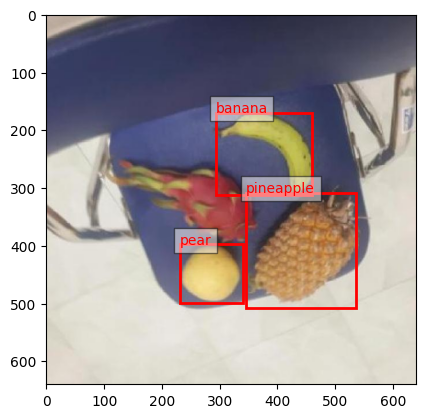

{5109: {'box': array([346, 308, 536, 508], dtype=object), 'label': 'pineapple'}, 5110: {'box': array([231, 397, 340, 498], dtype=object), 'label': 'pear'}, 5111: {'box': array([293, 169, 460, 312], dtype=object), 'label': 'banana'}}
{5109: {'box': array([131, 117, 204, 193]), 'label': 'pineapple'}, 5110: {'box': array([ 88, 151, 129, 189]), 'label': 'pear'}, 5111: {'box': array([111,  64, 175, 118]), 'label': 'banana'}}


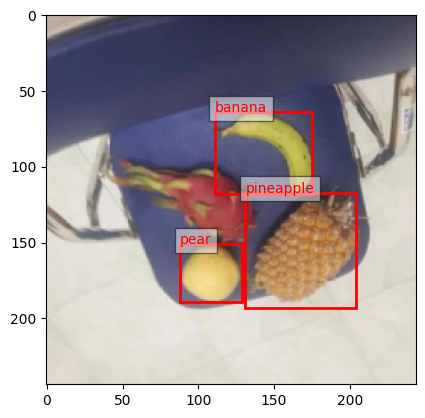

In [13]:
# Let's resize our first image using _resize_image_and_boxes

# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(first_plt_img, first_boxes, input_size, input_size)

# Print the resized boxes
print(first_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

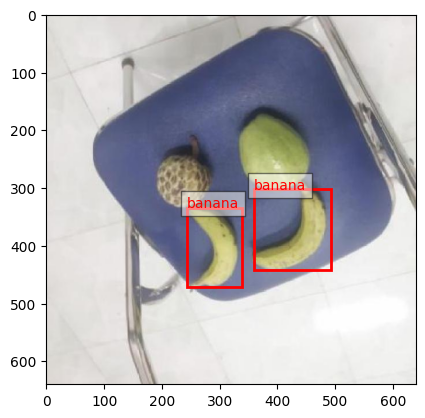

{4234: {'box': array([359, 302, 493, 442], dtype=object), 'label': 'banana'}, 4235: {'box': array([243, 334, 339, 471], dtype=object), 'label': 'banana'}}
{4234: {'box': array([136, 115, 187, 168]), 'label': 'banana'}, 4235: {'box': array([ 92, 127, 129, 179]), 'label': 'banana'}}


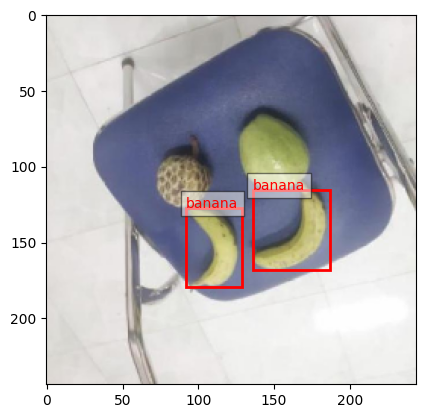

In [14]:
# Another random example
x = random.randint(0, len(train_image_files))

# Image file is at index x
random_image_path = train_image_files[x]
random_filename = os.path.basename(random_image_path)
random_plt_img = plt.imread(random_image_path)
random_boxes = get_boxes_for_image(random_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(random_plt_img, random_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(random_plt_img, random_boxes, input_size, input_size)

# Print the resized boxes
print(random_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

In [15]:
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

import tensorflow as tf
print(tf.__version__)

2.17.1


## Data preparation

This is where the magic happens - we prepare the data for our model.

### Key points:<br/>
**Adding the Channel Dimension:** If your image data is grayscale, it might initially only have three dimensions (batch size, height, width). Using np.expand_dims(X, axis=3) adds a fourth dimension to represent the channel, even if it's just a single grayscale channel.

**Why it's Important**

Compatibility with CNN Layers: CNN layers are designed to operate on multi-channel data. By adding the channel dimension, you ensure that your data is compatible with these layers.
Flexibility: Even if you're currently working with grayscale images, adding the channel dimension allows you to easily switch to using color images in the future without having to significantly modify your code.

In [16]:
# # prompt: please check for filenames without a label banana

# # Iterate through the annotations and find filenames without 'banana' label
# filenames_without_banana = []
# for filename in set(train_annotations['filename']):
#     boxes = get_boxes_for_image(filename, train_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana.append(filename)
#     else:
#       filenames_without_banana.append(filename)

# print(f"Filenames without 'banana' label in training set: {filenames_without_banana}")

# #Repeat for test and validation sets
# filenames_without_banana_test = []
# for filename in set(test_annotations['filename']):
#     boxes = get_boxes_for_image(filename, test_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_test.append(filename)
#     else:
#       filenames_without_banana_test.append(filename)

# print(f"Filenames without 'banana' label in test set: {filenames_without_banana_test}")

# filenames_without_banana_validation = []
# for filename in set(validation_annotations['filename']):
#     boxes = get_boxes_for_image(filename, validation_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_validation.append(filename)
#     else:
#       filenames_without_banana_validation.append(filename)

# print(f"Filenames without 'banana' label in validation set: {filenames_without_banana_validation}")

In [17]:
# data loader
def data_load(image_files, annotations):

    X = []
    Y = []

    # print(image_files[0])
    for image_file in image_files:
    # for image_file in image_files[:10]:
        img = cv.imread(os.path.join(image_file), cv.IMREAD_GRAYSCALE)
        boxes = get_boxes_for_image(os.path.basename(image_file), annotations)
        # print(boxes)

        # check for banana
        is_banana = False
        for box in boxes.values():
          # print(box['label'])
          if box['label'] == 'banana':
            is_banana = True
            break
        if not is_banana:
          # we include only images with bananas for now
          print('no banana')
          continue

        # print(boxes)

        # resize image and boxes
        img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)
        # print(img)
        # print(boxes)
        for index, box in boxes.items():
          # print(box)
          # print(box['box'])
          # print(box['label'])
          if box['label'] == 'banana':
            label = 1
            box = np.array(box['box'], dtype=float)
            # print(box)
            # we only apply the first banana box
            # print('continue')
            break


        img = img.astype(float) / 255.
        # print(img)
        # print(box)
        # we already have a float array
        box = np.asarray(box, dtype=float)
        # we wait with normalizing the bounding boxes
        # box = box / input_size
        # print(box)
        # box = np.append(box, label)
        label = np.append(box, label)
        # print(label)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    Y = np.array(Y)
    # print(X)
    # print(Y)

    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

# data_load(train_image_files, train_annotations)
# data_load(validation_image_files, validation_annotations)

In [20]:
raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

In [45]:
# raw_train_ds = data_load(train_image_files, train_annotations)
# raw_validation_ds = data_load(validation_image_files, validation_annotations)
# raw_test_ds = data_load(test_image_files, test_annotations)

The training, validation & test datasets must be set up in order to follow the tensorflow guideline (https://www.tensorflow.org/datasets/performances):

In [22]:
!pwd

/content/drive/MyDrive/assignment-computer-vision


In [43]:
# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

In [24]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [25]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [26]:
train_ds = tune_training_ds(raw_train_ds)

In [27]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_image_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [28]:
validation_ds = tune_validation_ds(raw_validation_ds)

In [53]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(test_image_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [54]:
test_ds = tune_test_ds(raw_test_ds)

### Dataset ispection

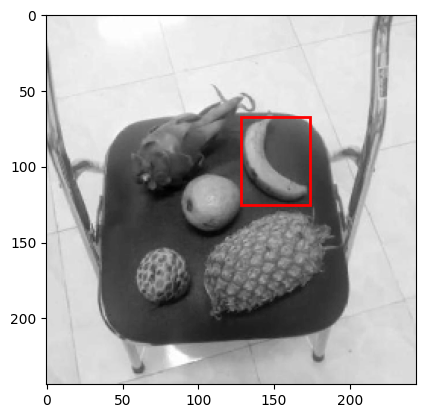

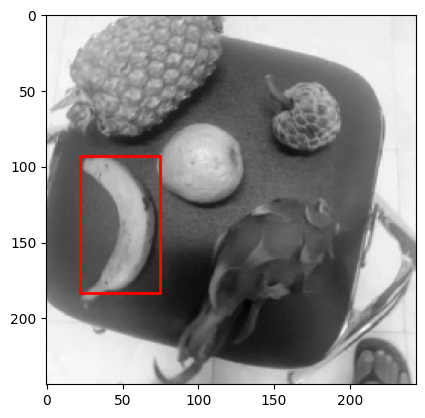

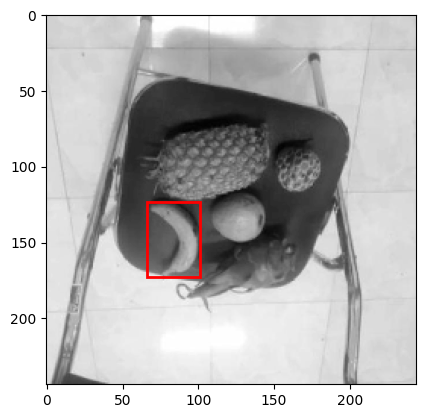

In [29]:
# Inspect the first image from the training_ds with boxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'train_ds' is your TensorFlow dataset and the first element is available
for image, (label, box) in train_ds.take(3):
    # Convert the image to a NumPy array and remove the batch dimension
    image = image.numpy()[0, :, :, 0]  # Assuming grayscale image and removing channel dim

    # print(label, box)

    # Accessing the bounding box coordinates and label
    xmin = box[0][0].numpy()
    ymin = box[0][1].numpy()
    xmax = box[0][2].numpy()
    ymax = box[0][3].numpy()
    # print(xmin, ymin, xmax, ymax)
    label = label[0].numpy()
    # print(label)


    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')  # Display grayscale image

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display the plot
    plt.show()

## The model

We are building a object detector, our model has two heads: one to classify the object type (or label or class) and other head to output the object bounding box.

In [30]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units=4, name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

It is notewhortly that each network head has a specific set of loss function and metrics:

In [31]:
model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 244, 244, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 242, 242, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 121, 121, 16)   │              0 │ conv2d[0][0]           │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 119, 119, 32)   │          4,640 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 59, 59, 32)     │              0 │ conv2d_1[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 57, 57, 64)     │         18,496 │ average_pooling2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 57, 57, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 28, 28, 64)     │              0 │ dropout[0][0]          │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50176)          │              0 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │      3,211,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_head (Dense)   │ (None, 2)              │            130 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regressor_head (Dense)    │ (None, 4)              │            260 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

We keep the model small for now:

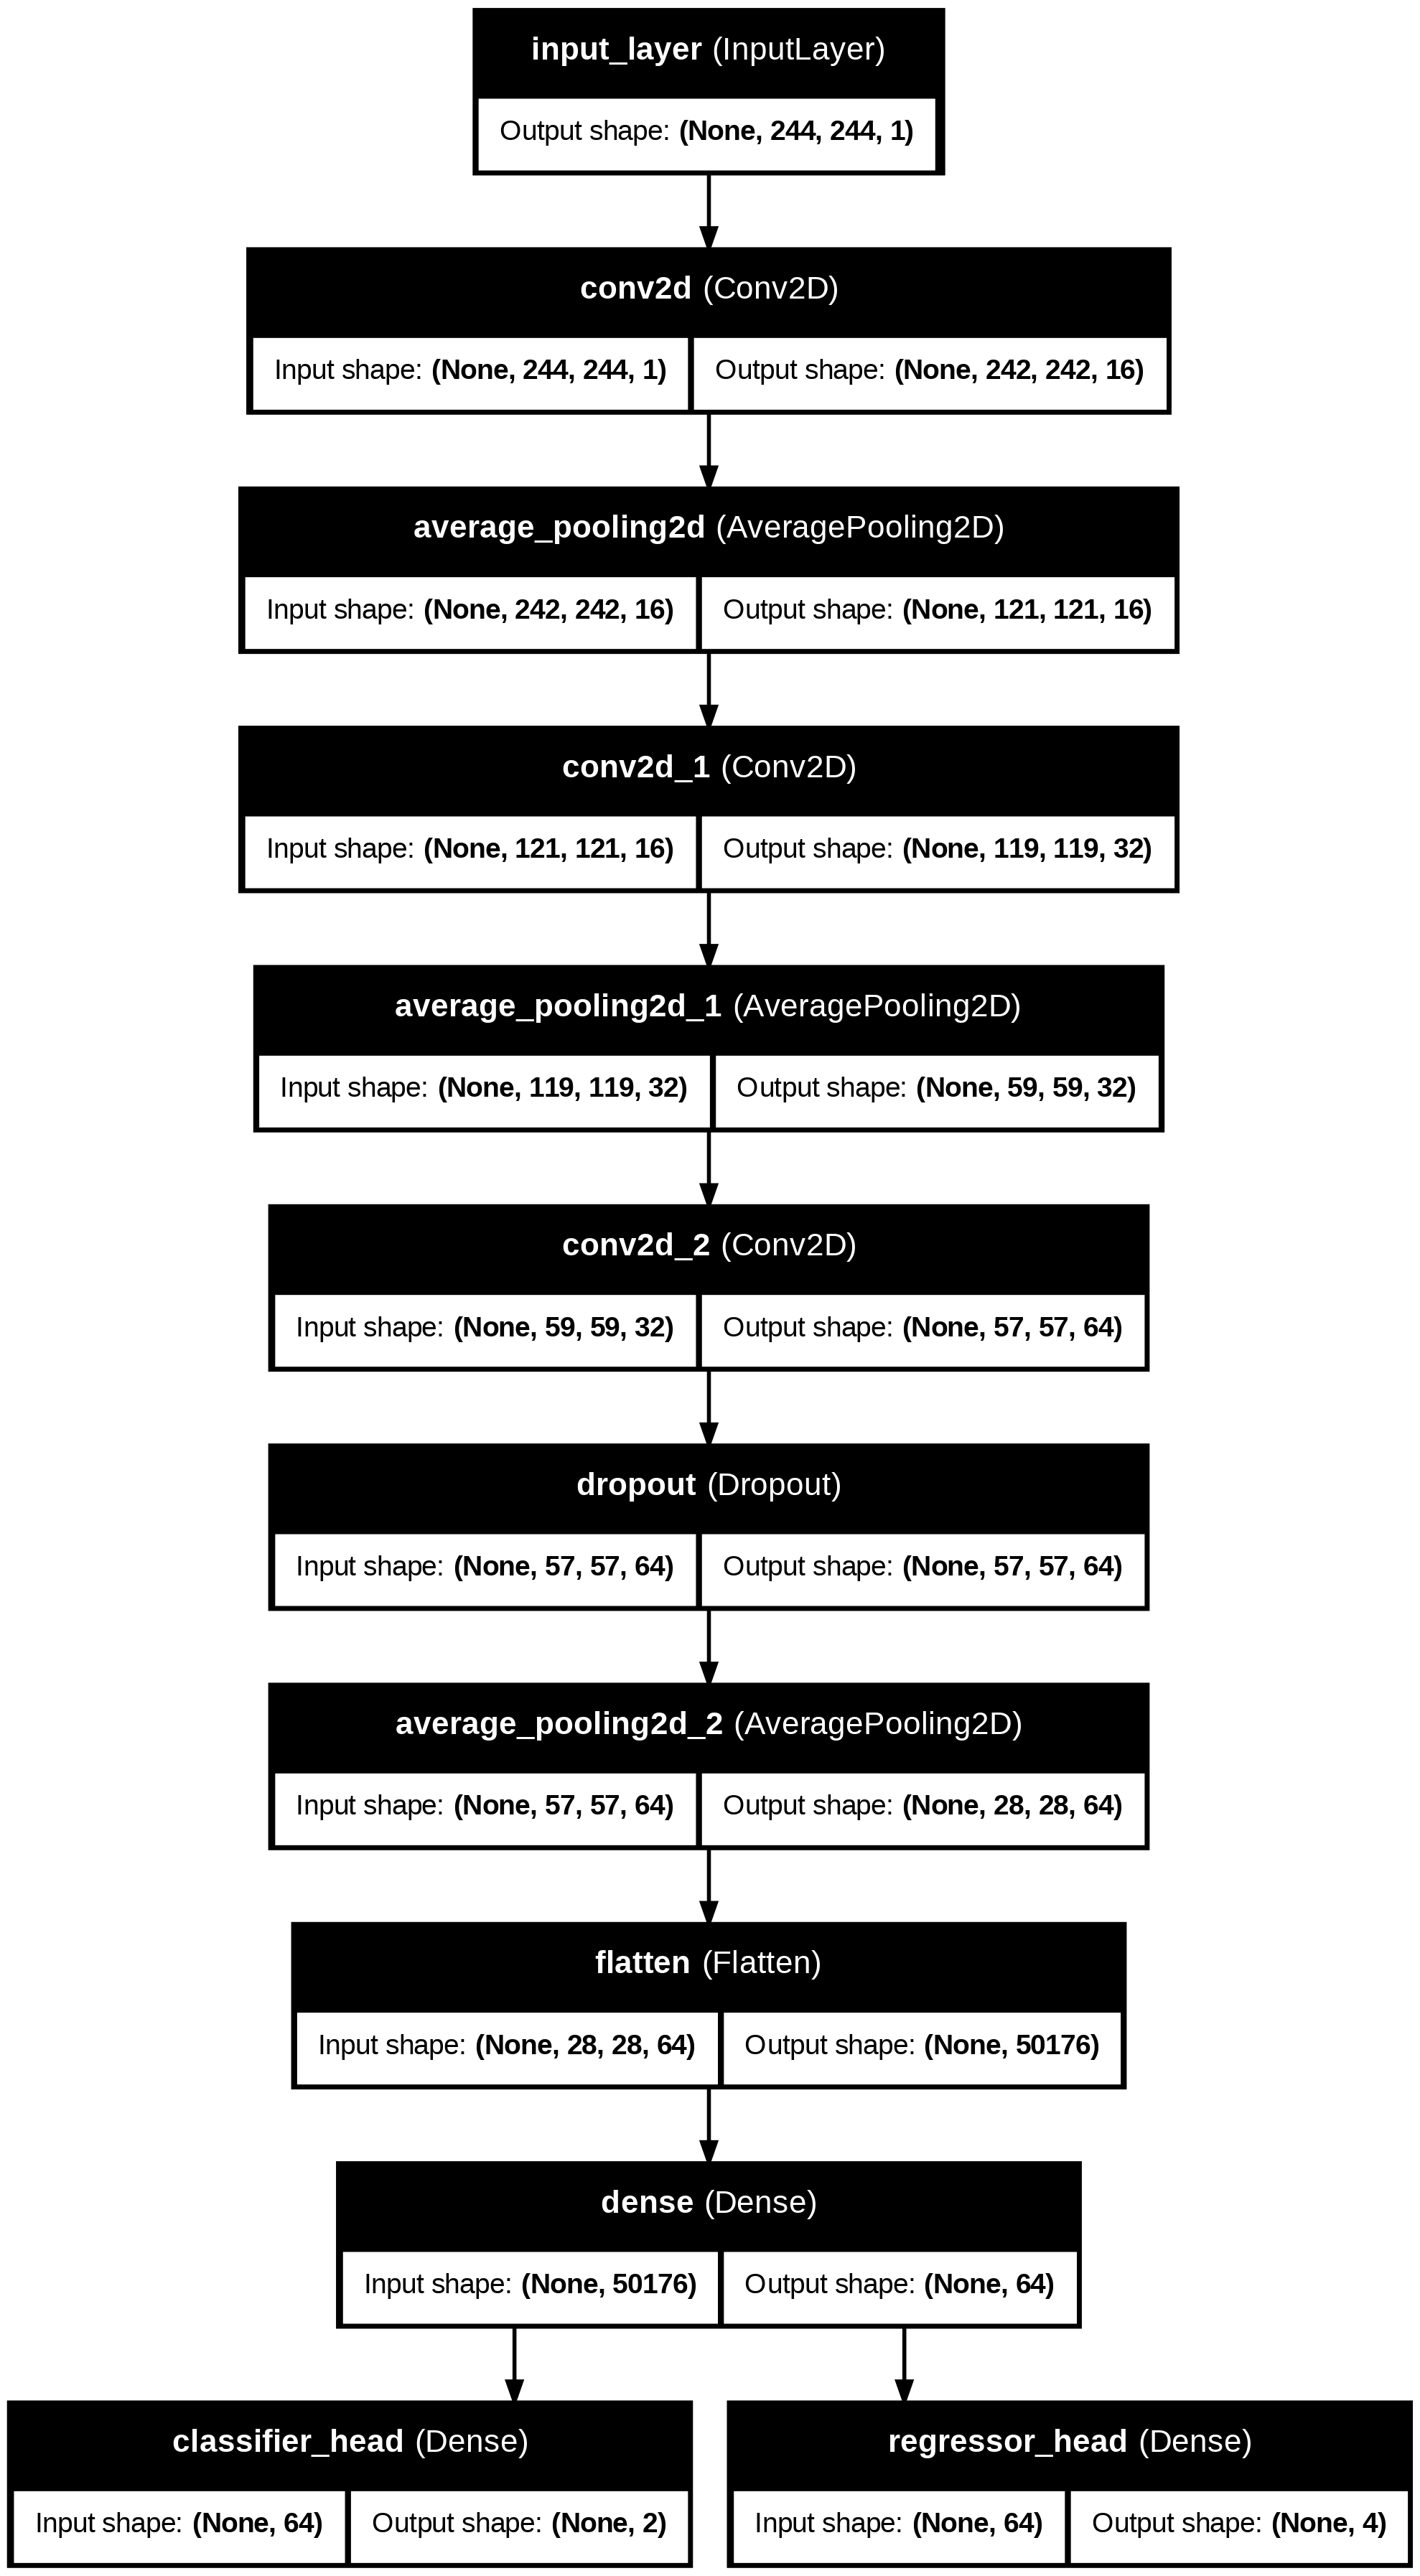

In [32]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [67]:
EPOCHS = 500

model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(train_ds,
                    steps_per_epoch=(len(train_image_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    callbacks=[reduce_lr] # Add callback to model.fit
                    )

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - classifier_head_accuracy: 0.9956 - classifier_head_loss: 0.0553 - loss: 6429.2827 - regressor_head_loss: 6429.2271 - regressor_head_mse: 6429.2271 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0000e+00 - val_loss: 2712.0640 - val_regressor_head_loss: 2712.0640 - val_regressor_head_mse: 2712.0640 - learning_rate: 0.0010
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - classifier_head_accuracy: 1.0000 - classifier_head_loss: 0.0000e+00 - loss: 2600.0581 - regressor_head_loss: 2600.0581 - regressor_head_mse: 2600.0581 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0000e+00 - val_loss: 2570.3320 - val_regressor_head_loss: 2570.3320 - val_regressor_head_mse: 2570.3320 - learning_rate: 0.0010
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - classifier_head_accuracy: 1.0000 - classifier_head_loss: 0.0000e+00 - loss: 2446.6868 - regressor_head_loss: 2446.6868 - regressor_head_mse: 2446.6868 - val_c

In [66]:
# EPOCHS = 250

# history = model.fit(train_ds,
#                     steps_per_epoch=(len(train_image_files) // BATCH_SIZE),
#                     validation_data=validation_ds, validation_steps=1,
#                     epochs=EPOCHS
#                     # ,verbose=0
#                     )

Check performance

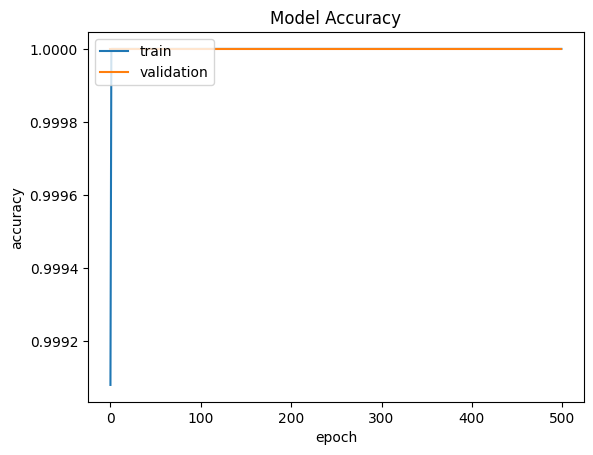

In [68]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

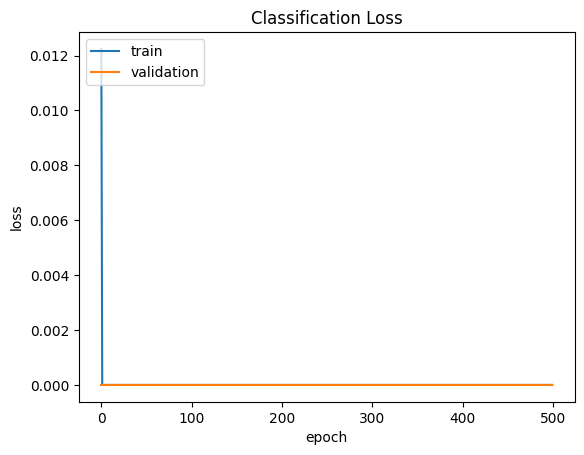

In [69]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

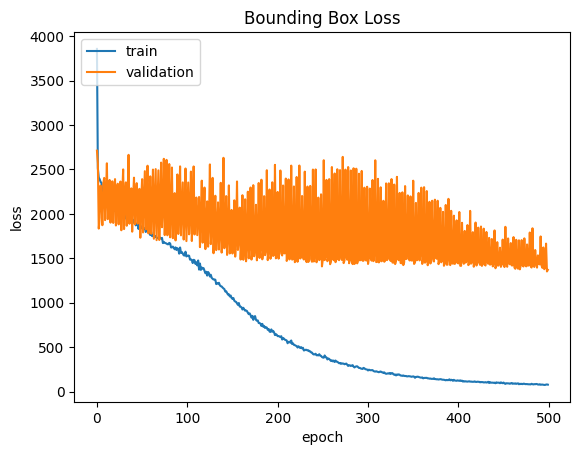

In [70]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [71]:
# IoU evaluation

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A NumPy array representing the first bounding box [xmin, ymin, xmax, ymax].
        box2: A NumPy array representing the second bounding box [xmin, ymin, xmax, ymax].

    Returns:
        The IoU value (a float between 0 and 1).
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

53
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
(244, 244, 1)
Image 0: True Label: 1 Pred Label: 1, True box [143.  75. 200. 109.] Pred box [124.777374  51.02512  189.45493  102.81381 ]
Image 0: IoU: 0.32338780267606043


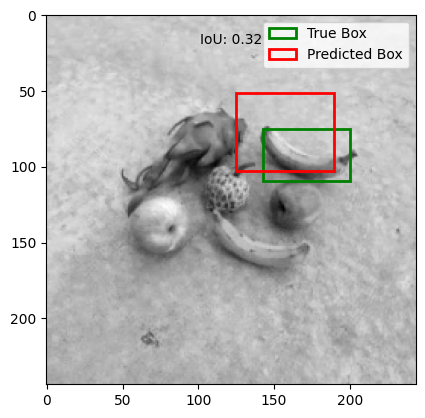

(244, 244, 1)
Image 1: True Label: 1 Pred Label: 1, True box [ 79.  47. 118.  97.] Pred box [ 59.897354  71.71678  114.98346  131.50699 ]
Image 1: IoU: 0.209924552882498


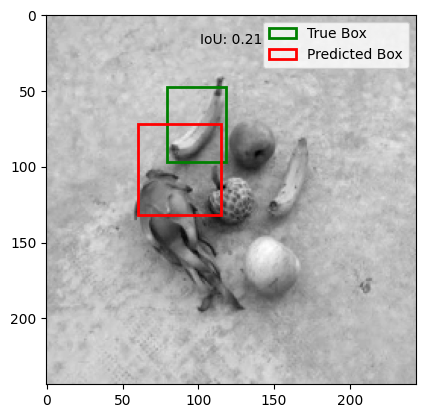

(244, 244, 1)
Image 2: True Label: 1 Pred Label: 1, True box [ 58.  66.  83. 118.] Pred box [ 52.51055  62.06691 106.35496 111.34435]
Image 2: IoU: 0.4020308296901792


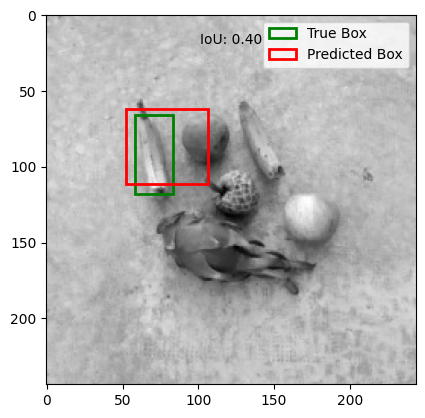

(244, 244, 1)
Image 3: True Label: 1 Pred Label: 1, True box [67. 41. 93. 99.] Pred box [ 85.855576  70.928215 124.64802  133.76912 ]
Image 3: IoU: 0.053550407289391144


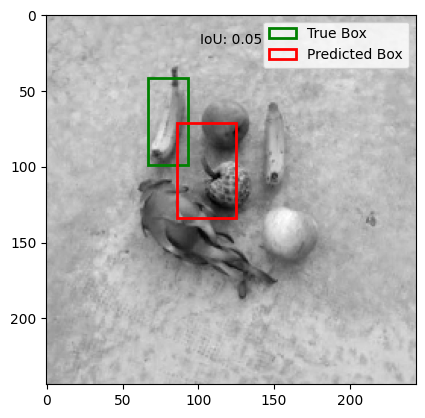

(244, 244, 1)
Image 4: True Label: 1 Pred Label: 1, True box [110. 139. 196. 176.] Pred box [112.04704  66.62775 189.98051 118.19035]
Image 4: IoU: 0.0


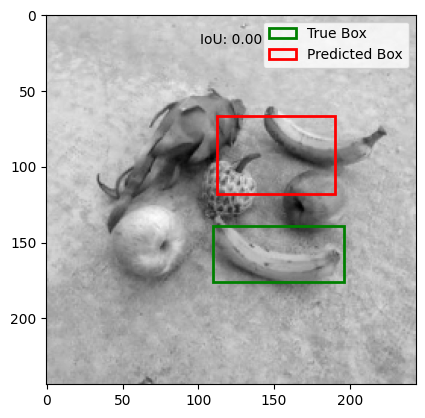

(244, 244, 1)
Image 5: True Label: 1 Pred Label: 1, True box [106. 129. 174. 170.] Pred box [123.27468  68.88306 190.14548 121.79895]
Image 5: IoU: 0.0


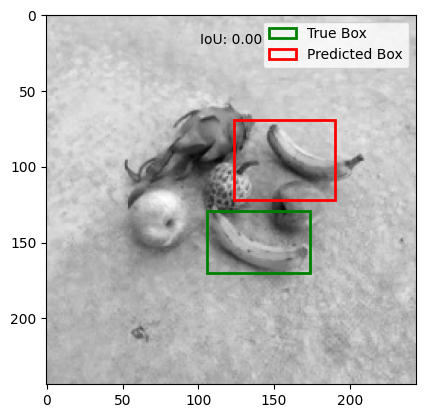

(244, 244, 1)
Image 6: True Label: 1 Pred Label: 1, True box [ 15. 151. 100. 199.] Pred box [109.66945 102.08343 170.7341  166.5192 ]
Image 6: IoU: 0.0


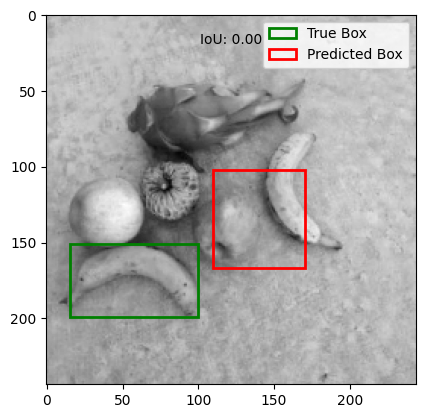

(244, 244, 1)
Image 7: True Label: 1 Pred Label: 1, True box [ 43.  88.  77. 139.] Pred box [ 56.683292  79.04257  114.697784 134.20686 ]
Image 7: IoU: 0.23495383665937503


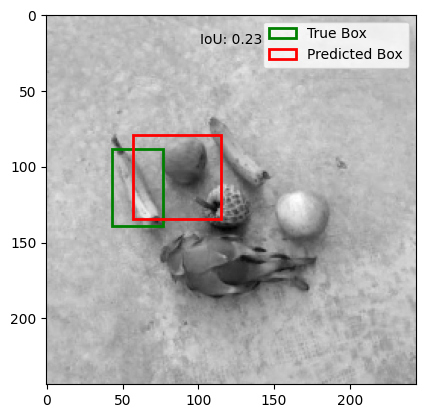

(244, 244, 1)
Image 8: True Label: 1 Pred Label: 1, True box [ 78.  48. 178.  79.] Pred box [ 93.72583  69.92672 193.17642 126.27954]
Image 8: IoU: 0.09630657150495303


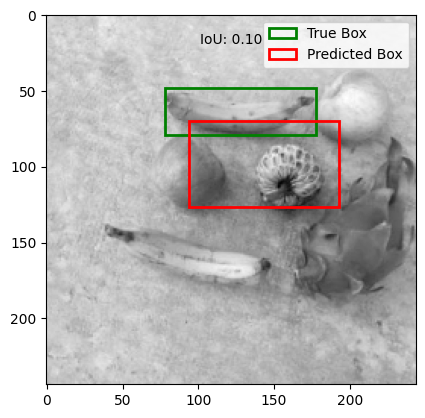

(244, 244, 1)
Image 9: True Label: 1 Pred Label: 1, True box [ 48. 120. 117. 156.] Pred box [ 61.27349   63.340435 126.90315  117.10647 ]
Image 9: IoU: 0.0


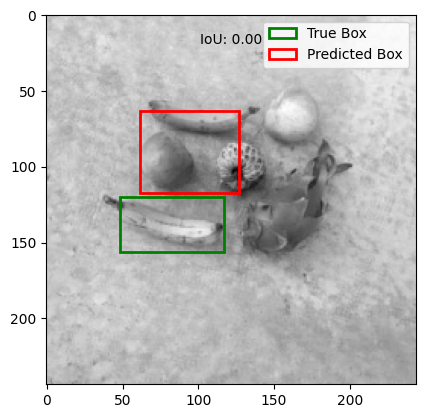

In [72]:
# Predict some examples from the test set

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

for image, (label, box) in test_ds.take(1):  # Get the first batch
    print(len(image))
    # Get predictions
    predictions = model.predict(image)

    # Assuming 'predictions' is a tuple with classification and bounding box
    predicted_labels = predictions[0]
    predicted_boxes = predictions[1]


    for i in range(10): # predict 10 images from the batch
        # Convert image to NumPy array
        print(image[i].numpy().shape)
        img = image[i].numpy()[:, :, 0]

        # Get true values
        true_label = label[i].numpy().argmax()
        true_box = box[i].numpy()

        # Get predicted values
        pred_label = predicted_labels[i].argmax()
        pred_box = predicted_boxes[i]
        print(f"Image {i}: True Label: {true_label} Pred Label: {pred_label}, True box {true_box} Pred box {pred_box}")

        # Create plot
        fig, ax = plt.subplots(1)
        ax.imshow(img, cmap='gray')

        # Add true bounding box
        rect_true = patches.Rectangle((true_box[0], true_box[1]), (true_box[2]-true_box[0]), (true_box[3]-true_box[1]), linewidth=2, edgecolor='g', facecolor='none', label='True Box')
        ax.add_patch(rect_true)

        # Add predicted bounding box
        rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), (pred_box[2]-pred_box[0]), (pred_box[3]-pred_box[1]), linewidth=2, edgecolor='r', facecolor='none', label='Predicted Box')
        ax.add_patch(rect_pred)

        ax.legend()

        # Calculate IoU
        iou = calculate_iou(true_box, pred_box)
        print(f"Image {i}: IoU: {iou}")

        # Add IoU to the plot (optional)
        plt.text(0.5, 0.95, f"IoU: {iou:.2f}", ha='center', va='top', transform=ax.transAxes)  # Position the text

        # Display the plot
        plt.show()